# Lublin House Prices Prediction

In [46]:
# ================== General Libraries ==================
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import re  # Regular expressions
import warnings  # Suppress warnings

# ================== Visualization Libraries ==================
import matplotlib.pyplot as plt  # Plotting
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import seaborn as sns  # Enhanced visualizations

# ================== Machine Learning ==================
# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Clustering
from sklearn.cluster import DBSCAN

# ================== Model Interpretation ==================
import shap  # SHapley Additive exPlanations
import lime  # Local Interpretable Model-agnostic Explanations
import lime.lime_tabular

# ================== Evaluation Metrics ==================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================== Configure Warnings ==================
warnings.filterwarnings("ignore")  # Ignore warnings for clean output

## Data preprocessing

In [59]:
data = pd.read_csv('data/houses_data.csv')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3182 non-null   object
 1   Name      3182 non-null   object
 2   Rooms     3182 non-null   object
 3   Area      3182 non-null   object
 4   Floor     3121 non-null   object
 5   Region    3182 non-null   object
 6   Year      3182 non-null   object
 7   Elevator  3182 non-null   object
dtypes: object(8)
memory usage: 199.0+ KB


In [61]:
data = data.drop("Name", axis=1)

In [62]:
print("\nUnique values in each column (excluding 'Price' and 'Area'):")
for column in data.columns:
    if column not in ['Price', 'Area']:
        unique_values = data[column].unique()
        print(f"{column}: {unique_values}")


Unique values in each column (excluding 'Price' and 'Area'):
Rooms: ['4 pokoje' '2 pokoje' '3 pokoje' '1 pokój' '5 pokoi' '6 pokoi'
 '10+ pokoi' '7 pokoi']
Floor: ['3 piętro' '2 piętro' '1 piętro' nan '10+ piętro' '10 piętro' '4 piętro'
 'parter' '6 piętro' '5 piętro' '9 piętro' '7 piętro' '8 piętro'
 'suterena' 'poddasze']
Region: ['Rury' 'Czechów Północny' 'Wrotków' 'Czechów Południowy' 'Kośminek'
 'Wieniawa' 'Ponikwoda' 'Śródmieście' 'Bronowice' 'Węglin Południowy'
 'Dziesiąta' 'Tatary' 'Felin' 'Kalinowszczyzna' 'Sławin' 'Czuby Północne'
 'Konstantynów' 'Szerokie' 'Czuby Południowe' 'Stare Miasto'
 'Za Cukrownią' 'Zemborzyce' 'Węglin Północny' 'Hajdów-Zadębie']
Year: ['brak informacji' '2025' '2026' '2023' '2015' '1980' '1982' '2008' '2024'
 '2018' '2003' '2021' '1976' '1963' '2017' '1969' '2000' '1978' '1975'
 '1983' '1993' '1974' '1995' '2022' '1994' '1897' '1986' '1984' '2010'
 '1988' '1973' '1996' '1967' '1972' '1964' '1998' '2014' '1990' '1977'
 '2005' '2012' '2016' '1985' '19

### Change the data type of the columns

In [63]:
# Replace 'Zapytaj o cenę' with NaN
data['Price'] = data['Price'].replace('Zapytaj o cenę', np.nan)
# Remove non-numeric characters, replace commas with dots, and convert to float, while keeping NaN values
data['Price'] = data['Price'].str.replace('\xa0', '').str.replace('zł', '').str.replace(',', '.').astype('float32')

In [64]:
# Remove non-numeric characters and convert 'Area' to float
data['Area'] = data['Area'].str.replace(' ', '').str.replace('m²', '').astype('float32')

In [65]:
# Replace 'brak informacji' with NaN in 'Year' column
data['Year'] = data['Year'].replace('brak informacji', np.nan)
# Convert 'Year' to integer, while keeping NaN values
data['Year'] = data['Year'].astype(float).astype('Int32')

In [ ]:
# Convert 'Elevator' column to 0 if 'nie' and 1 if 'tak'
data['Elevator'] = data['Elevator'].replace({'nie': 0, 'tak': 1}).astype('int32')

In [67]:
# Count the number of rows for each unique value in 'Rooms' column
room_counts = data['Rooms'].value_counts()
print("Number of rows for each unique value in 'Rooms' column:")
print(room_counts)

Number of rows for each unique value in 'Rooms' column:
Rooms
3 pokoje     1364
2 pokoje     1124
4 pokoje      404
1 pokój       232
5 pokoi        46
6 pokoi         7
7 pokoi         3
10+ pokoi       2
Name: count, dtype: int64


In [ ]:
# Replace '10+ pokoi' with '10 pokoi' in 'Rooms' column
data['Rooms'] = data['Rooms'].replace('10+ pokoi', '10 pokoi')
# Extract numeric part and convert 'Rooms' to integer
data['Rooms'] = data['Rooms'].str.extract('(\d+)').astype('int32')

In [69]:
# Drop rows with missing values in 'Price' column
data = data.dropna(subset=['Price'])

In [70]:
# Reorder columns
data = data[['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']]

In [71]:
# Assuming 'data' is your DataFrame
missing_data = data.isnull().sum()
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
Price         0
Area          0
Elevator      0
Year        430
Rooms         0
Floor        61
Region        0
dtype: int64


In [72]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,567000.0,52.500000,0,<NA>,4,3 piętro,Rury
1,728500.0,77.500000,1,2025,4,3 piętro,Czechów Północny
2,668360.0,68.199997,1,2026,4,2 piętro,Wrotków
3,833414.0,76.459999,1,2023,4,1 piętro,Czechów Południowy
4,696500.0,79.599998,1,2025,4,NaN,Kośminek


In [73]:
data.dtypes

Price       float32
Area        float32
Elevator      int32
Year          Int32
Rooms         int32
Floor        object
Region       object
dtype: object

In [74]:
# Calculate the number of rows with both 'Floor' and 'Region' missing values
missing_floor_region = data[data['Floor'].isnull() & data['Region'].isnull()].shape[0]
print(f"Number of rows with both 'Floor' and 'Region' missing values: {missing_floor_region}")

Number of rows with both 'Floor' and 'Region' missing values: 0


There are 0 rows which has mising values at the same time in the columns 'Floor' and 'Region', so it is bad idea to drop all NA values, because we will lose near 500 rows from the dataset. Instead of this, we will fill the missing values in the 'Floor' column with the median value.

### Impute missing values

#### Floors

Use median value to fill missing values in the 'Floor' column.

In [79]:
# Count the occurrences of each unique value in the 'Floor' column
floor_counts = data['Floor'].value_counts(dropna=False)
# Display the counts for each unique value
print("Number of rows for each unique value in 'Floor' column:")
print(floor_counts)

Number of rows for each unique value in 'Floor' column:
Floor
3 piętro      549
2 piętro      541
1 piętro      531
parter        491
4 piętro      285
5 piętro      112
6 piętro       73
NaN            61
7 piętro       50
10 piętro      32
9 piętro       31
8 piętro       15
10+ piętro      8
suterena        1
poddasze        1
Name: count, dtype: int64


Change 10+ piętro and poddasze to 10 piętro, suterena to parter

In [80]:
data['Floor'] = data['Floor'].replace({
    'suterena': 'parter',
    'poddasze': 'parter',
    '10+ piętro': '10 piętro'
})

In [86]:
# Extract numeric part from 'Floor' column, forcing errors to NaN
floor_numeric = data['Floor'].str.extract(r'(\d+)').astype(float)
# Calculate the median of the 'Floor' column, excluding NaN values
median_floor = floor_numeric.dropna().median()[0]
print(f"Median of the 'Floor' column: {median_floor}")

Median of the 'Floor' column: 3.0


In [90]:
# Replace all NaN values in 'Floor' column with '3 piętro'
data['Floor'] = data['Floor'].fillna('3 piętro')

#### Years

Year column has very large number of missing values, so we will fill them with regression but first check the correlation between the year and other columns.

In [117]:
data['Year'] = data['Year'].replace({87: 1987, 1: np.nan})

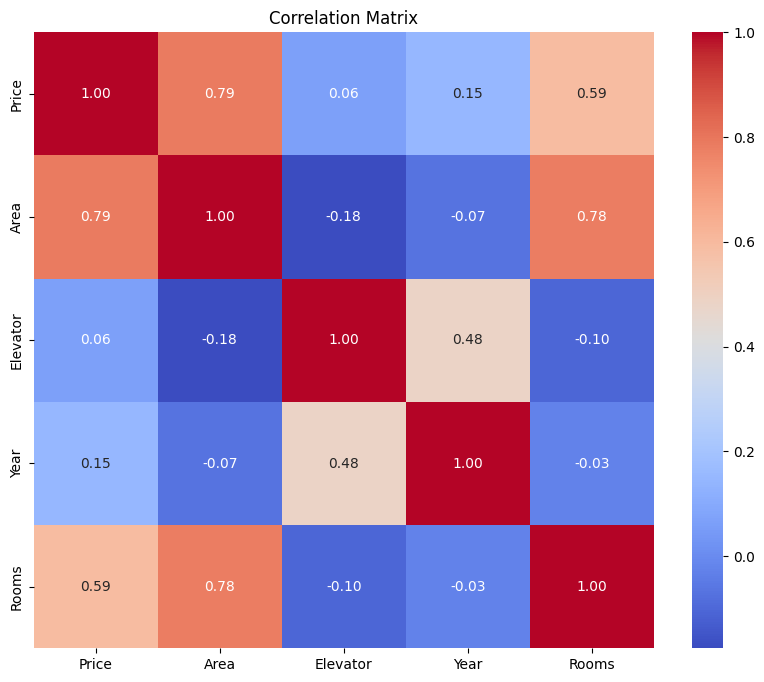

In [120]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Year column has very low correlation with other columns, only with the Elevator column has correlation approximately 0.5, so we will make a column `Year_interval` and fill missing values with year interval of the building and also consider whether there is a lift in the building, as older buildings may not have one

Make new column `Year_interval`.

In [121]:
# Define the bins and labels for the intervals
bins = [-np.inf, 1890, 1920, 1950, 1980, 2001, 2016, np.inf]
labels = ['<1890', '1891-1920', '1921-1950', '1951-1980', '1981-2001', '2001-2016', '2016<']

# Create the 'Year_interval' column using pd.cut()
data['Year_interval'] = pd.cut(data['Year'], bins=bins, labels=labels, right=False)

# Display the first few rows to verify the changes
print(data[['Year', 'Year_interval']].head())

   Year Year_interval
0  <NA>           NaN
1  2025         2016<
2  2026         2016<
3  2023         2016<
4  2025         2016<


In [122]:
data["Year_interval"].value_counts()

Year_interval
2016<        1232
1951-1980     426
1981-2001     365
2001-2016     238
1891-1920      45
1921-1950      39
<1890           5
Name: count, dtype: int64

See that most building are in 2016< and 1951-1980 years, so we will fill missing values with these intervals, depending on the availability of a elevator.

In [129]:
def fill_year_interval(row):
    if pd.isna(row['Year_interval']):
        if row['Elevator'] == 1:
            return '2016<'
        else:
            return '1951-1980'
    else:
        return row['Year_interval']

In [130]:
data['Year_interval'] = data.apply(fill_year_interval, axis=1)

In [132]:
data = data[['Price', 'Area', 'Elevator', 'Rooms', 'Floor', 'Region','Year_interval','Year']]

In [134]:
data.to_csv('data/houses_data_cleaned.csv', index=False)

## Exploratory Data Analysis

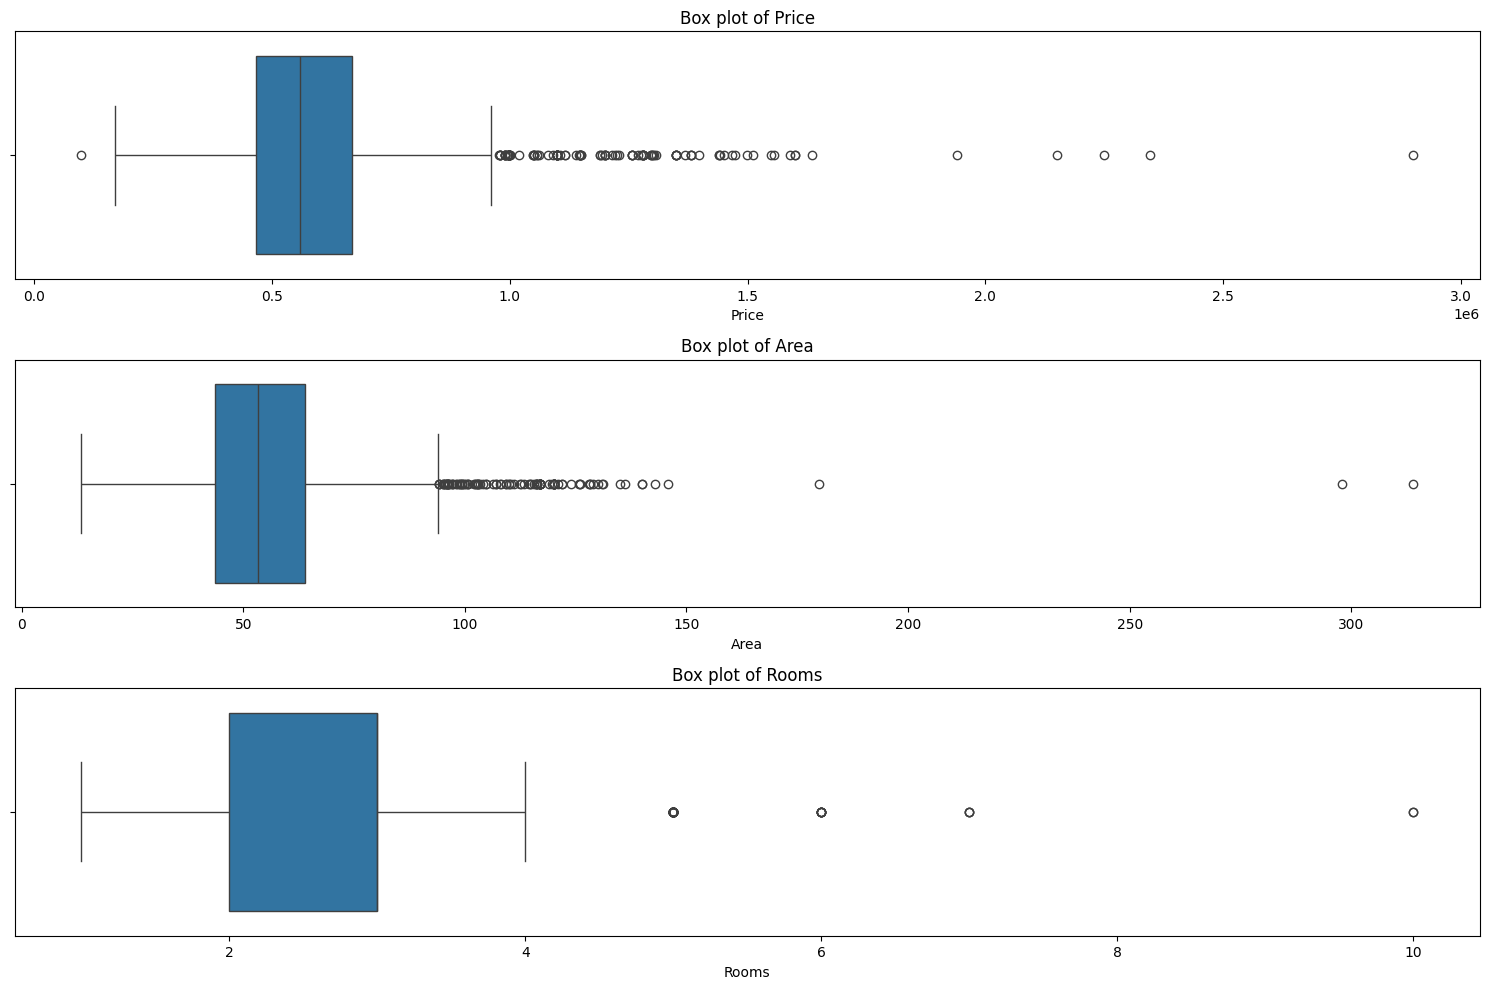

In [147]:
numerical_columns = ['Price', 'Area', 'Rooms']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=data[column], orient='h')
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

**Box Plot of Price**
Most house prices fall within a certain range, with a few outliers extending significantly beyond 1,500,000 PLN. The median price is located in the lower portion of the box, suggesting that most properties are closer to the lower price range.

**Box Plot of Area**
Most house areas are between approximately 30 sqm and 100 sqm, with the interquartile range (IQR) centered on typical apartment sizes.There are several outliers representing houses with exceptionally large areas (e.g., over 200 sqm).

**Box Plot of Rooms:**
Most houses have between 2 and 4 rooms, which matches the common configurations of apartments.

Lest explore anomalies in the data to see if we can find any patterns in them and shoul we remove them or not.

Use the Interquartile Range (IQR) Method to detect and see the anomalies in the data.

In [166]:
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

price_outliers = find_outliers_iqr(data, 'Price')
area_outliers = find_outliers_iqr(data, 'Area')
room_outliers = find_outliers_iqr(data, 'Rooms')

all_outliers = pd.concat([price_outliers, area_outliers, room_outliers]).drop_duplicates()
all_outliers.head(20)

,Price,Area,Elevator,Rooms,Floor,Region,Year_interval,Year,Price_per_sqm,Outlier_DBSCAN
168,1350000.0,117.000000,1,4,2 piętro,Stare Miasto,2001-2016,2013,11538.461914,0
170,1599000.0,116.879997,1,5,6 piętro,Konstantynów,2016<,2018,13680.698242,0
203,1499000.0,88.199997,1,4,10 piętro,Czechów Południowy,2016<,2019,16995.464844,0
217,1080000.0,72.000000,0,4,parter,Śródmieście,1891-1920,1908,15000.000000,0
233,1299000.0,81.000000,1,3,10 piętro,Rury,2001-2016,2013,16037.037109,0
330,1099500.0,82.570000,1,4,3 piętro,Wrotków,2016<,<NA>,13315.974609,0
337,99000.0,19.000000,0,1,parter,Dziesiąta,1951-1980,<NA>,5210.526367,0
347,1050000.0,77.000000,0,3,1 piętro,Sławin,2016<,2023,13636.363281,0
356,1280000.0,92.000000,0,4,1 piętro,Sławin,2016<,2020,13913.043945,0
390,1149990.0,91.989998,0,4,1 piętro,Sławin,2016<,2019,12501.250000,0


In [167]:
len(all_outliers)

160

IQR method detected very large number of annomalies in the data, so we will not remove them, because they are not errors in the data, but just outliers, because there are some very expensive houses in Lublin.

Use DBSCAN to detect anomalies in the data.

In [190]:
numeric_data = data[['Price', 'Area', 'Rooms']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['Outlier_DBSCAN'] = dbscan.fit_predict(scaled_data)
dbscan_outliers = data[data['Outlier_DBSCAN'] == -1]
dbscan_outliers.head(15)

,Price,Area,Elevator,Rooms,Floor,Region,Year_interval,Year,Price_per_sqm,Outlier_DBSCAN
210,499000.0,128.000000,0,4,4 piętro,Tatary,1951-1980,1960,3898.437500,-1
800,1940000.0,314.000000,0,10,3 piętro,Wieniawa,1951-1980,<NA>,6178.343750,-1
1136,950000.0,90.830002,0,7,4 piętro,Śródmieście,1921-1950,1930,10459.099609,-1
2552,2150000.0,130.000000,1,4,10 piętro,Czechów Południowy,2001-2016,2013,16538.460938,-1
2643,2347058.0,145.779999,1,4,7 piętro,Śródmieście,2016<,2024,16100.000000,-1
2866,475000.0,124.000000,0,5,1 piętro,Kośminek,1981-2001,1980,3830.645264,-1
2937,2900000.0,298.000000,0,10,1 piętro,Szerokie,2001-2016,2003,9731.543945,-1
3056,999000.0,180.000000,0,5,3 piętro,Czechów Północny,1981-2001,1998,5550.000000,-1
3098,2250000.0,131.199997,1,5,10 piętro,Czechów Południowy,2016<,2020,17149.390625,-1


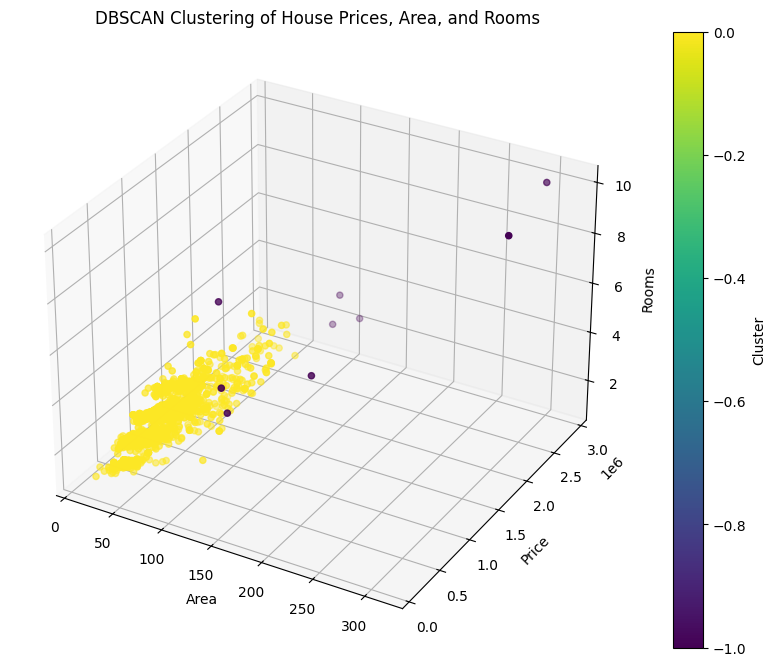

In [191]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data['Area'], data['Price'], data['Rooms'], c=data['Outlier_DBSCAN'], cmap='viridis', marker='o')
ax.set_xlabel('Area')
ax.set_ylabel('Price')
ax.set_zlabel('Rooms')
ax.set_title('DBSCAN Clustering of House Prices, Area, and Rooms')
fig.colorbar(scatter, label='Cluster')
plt.show()

DBSCAN detected 9 anomalies what is much better than IQR method, but if look at that data we can see that with them is everythink ok, so we will not remove them.

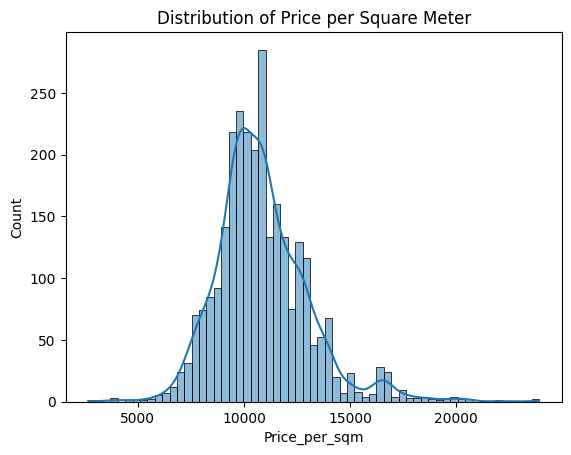

In [149]:
data.loc[:, 'Price_per_sqm'] = data['Price'] / data['Area']
sns.histplot(data=data, x='Price_per_sqm', kde=True)
plt.title('Distribution of Price per Square Meter')
plt.show()

The distribution is unimodal, with a clear peak around 10,000 PLN per square meter. This suggests that the majority of houses in Lublin have a price per square meter near this value.

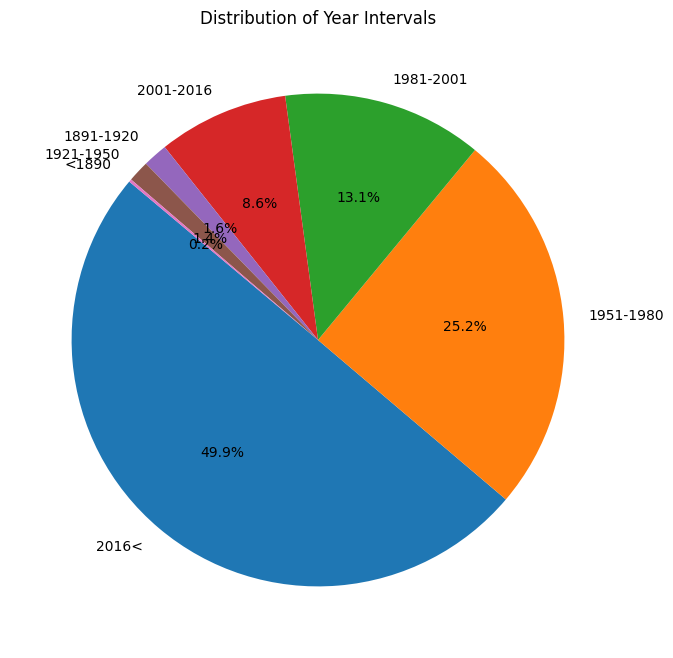

In [158]:
year_interval_counts = data['Year_interval'].value_counts()

# Create a pie plot
plt.figure(figsize=(8, 8))
plt.pie(year_interval_counts, labels=year_interval_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Year Intervals')
plt.show()

## Data preparation

In [4]:
data = pd.read_csv('data/houses_data_cleaned.csv')

In [5]:
data = data.drop("Year",axis=1)

In [6]:
# Separate target and features
target = data['Price']
features = data.drop('Price', axis=1)

In [7]:
# One-Hot Encoding for categorical variables
categorical_columns = ['Floor', 'Region', 'Year_interval']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = pd.DataFrame(
    encoder.fit_transform(features[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

In [8]:
# Drop original categorical columns and concatenate encoded features
features = features.drop(categorical_columns, axis=1)
features = pd.concat([features, encoded_cats], axis=1)

In [9]:
# Normalize numerical features
numerical_columns = ['Area', 'Rooms']
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [91]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 557, 2224, 557)

## Build models

### Linear Regression

Metrics: I desided to use `MAE` and $R^2$ as primary metrics, because they are easy to understand and interpret. Like secondary metrics I will use `RMSE` because this metric will penalize large errors more than MAE.

#### Build a model

In [93]:
# Build and train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Evaluate the model

Make a function which will evaluate the model and return the metrics as dataframe.

In [13]:
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate model performance
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)

    # Create a dataframe without MSE
    results = pd.DataFrame({
        'Metric': ['R^2', 'MAE', 'RMSE'],
        'Value': [r2, mae, rmse]
    })
    
    return results

In [95]:
results_linear_regression = evaluate_model(model, X_test, y_test)
results_linear_regression

,Metric,Value
0,R^2,0.743
1,MAE,66971.531
2,RMSE,103072.669


On average, the predictions are off by approximately 66,971 zł.The RMSE penalizes larger errors more heavily than MAE so this relatively higher value indicates on the outliers which were not removed from the data. $R^2$ indicates that 74.3% of the variance in the house prices is explained by the model.

#### SHAP analysis 

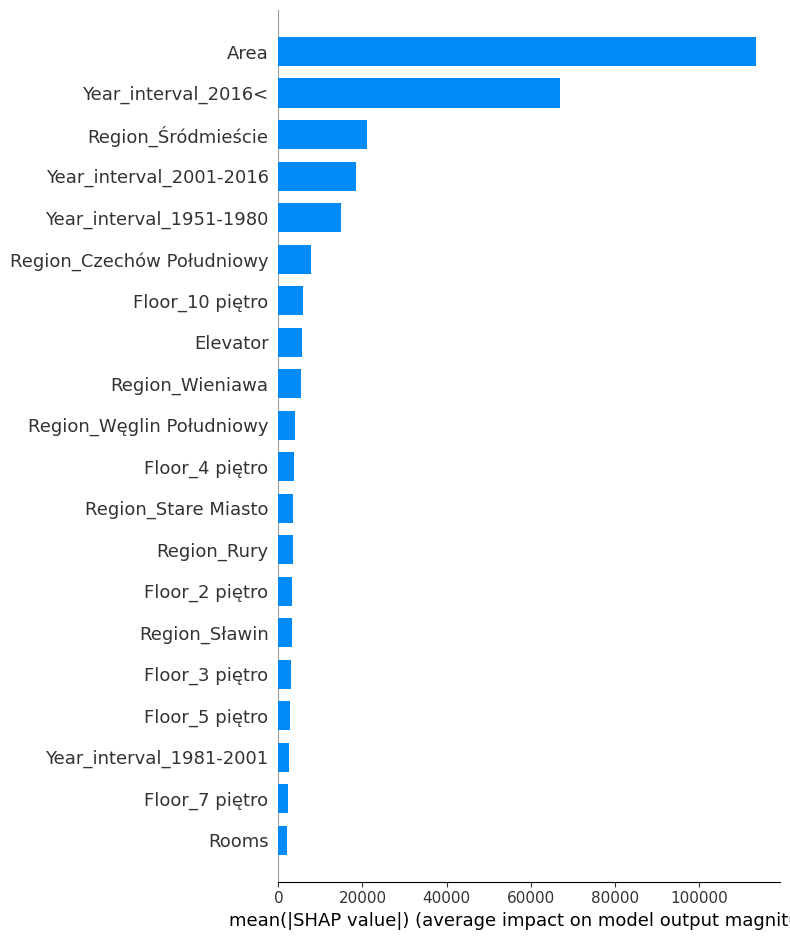

In [96]:
# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

Note that area has the highest impact on the model and it is logical, because the larger the area, the higher the price. Also year interval has very high impact on the model, especially the buildings 2001< and 1951-1980 years, 1981-2001 has much smaller impact. Elevator also has important impact on the model, rooms has very low impact, because the number of rooms depends on the area of the house. Few regions has also important impact on the model, especially Śródmieście and Czechów Południowy. Floor has very low impact, apart from the 10th floor.

Let's find the best and the worst predictions of the model.And try to analyze what variables, could have caused such a large error. And with what variables the model predicted the price very well.

In [97]:
# Predict the values
y_pred = model.predict(X_test)

# Find the best and worst predicted values
errors = np.abs(y_test.values - y_pred)
best_index = np.argmin(errors)
worst_index = np.argmax(errors)

# Print best and worst predictions
print(f"Best Prediction: Real Price: {y_test.iloc[best_index]}, Predicted Price: {y_pred[best_index]}")
print(f"Worst Prediction: Real Price: {y_test.iloc[worst_index]}, Predicted Price: {y_pred[worst_index]}")

Best Prediction: Real Price: 710000.0, Predicted Price: 709986.8920645511
Worst Prediction: Real Price: 1599000.0, Predicted Price: 1041638.9137565235


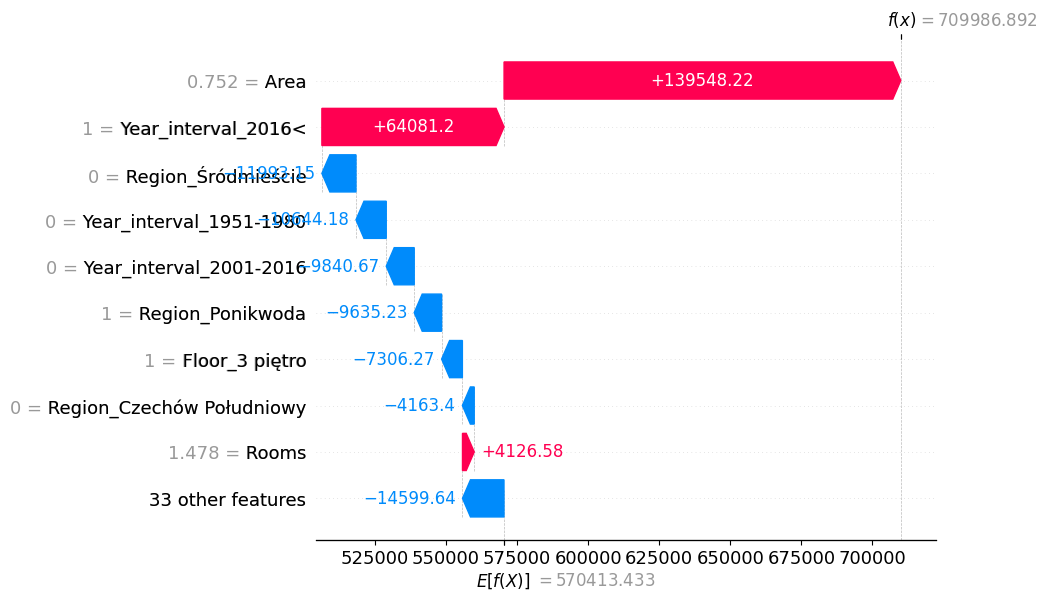

In [98]:
# Waterfall plot for best prediction
shap.waterfall_plot(shap.Explanation(values=shap_values[best_index].values, 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[best_index],
                                     feature_names=X_test.columns))
plt.show()

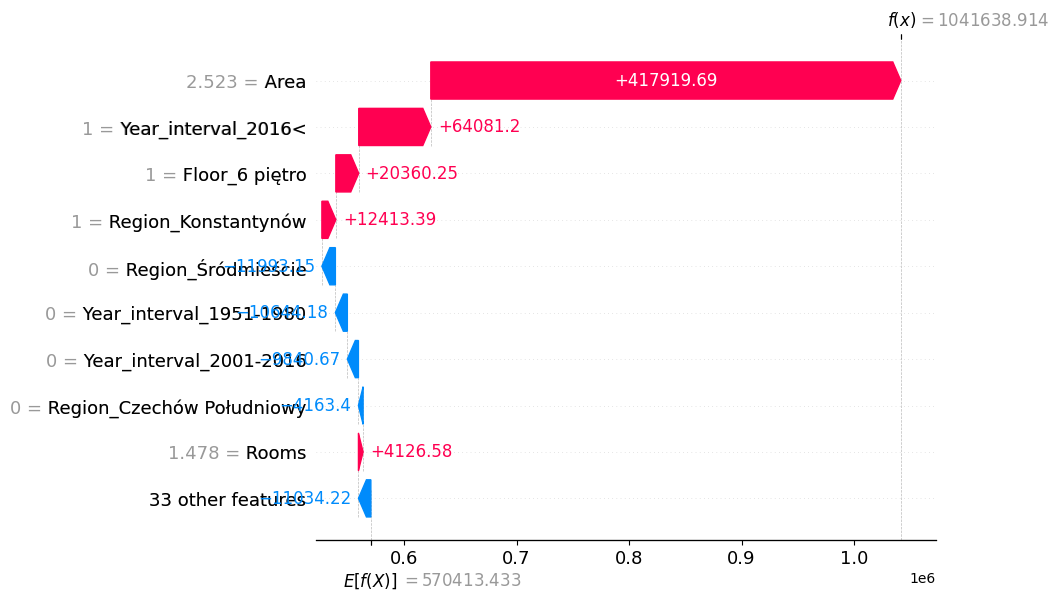

In [99]:

# Waterfall plot for worst prediction
shap.waterfall_plot(shap.Explanation(values=shap_values[worst_index].values, 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[worst_index]))
plt.show()

Because model had very low number of examples with very high price and large area houses, model couldn't predict that houses very well abd make very large errors, so the best solutions is to remove that outliers, but model couldn't predict well that type of houses, or another time-wasting solution is to collect more data with that type of houses.

### ElasticNet Regression 

Now let's try to use ElasticNet regression to see if it will improve the model. Also we will use GridSearchCV to find the best hyperparameters for the model.

#### Build a model

In [101]:
# ElasticNet Regression with GridSearchCV
elastic_net = ElasticNet()
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]  
}
elastic_search = GridSearchCV(elastic_net, elastic_params, cv=5, scoring='neg_mean_squared_error')
elastic_search.fit(X_train, y_train)
best_elastic = elastic_search.best_estimator_

#### Evaluate the model

In [102]:
# ElasticNet Regression Metrics
elastic_metrics = evaluate_model(best_elastic, X_test, y_test)

print("Best ElasticNet Regression Metrics (alpha={}, l1_ratio={}):".format(
    elastic_search.best_params_["alpha"], elastic_search.best_params_["l1_ratio"]), elastic_metrics)

Best ElasticNet Regression Metrics (alpha=0.1, l1_ratio=0.95):   Metric       Value
0    R^2       0.741
1    MAE   66910.695
2   RMSE  103447.970


ElasitcNet model has very similar results to the Linear Regression model, so there are no reasons to discover this model more.

### Decision Tree regression

#### Build a model

Use GridSearchCV to find the best hyperparameters for the model.

In [121]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
decision_tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search.fit(X_train, y_train)
best_decision_tree = grid_search.best_estimator_
best_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

In [122]:
# Evaluate Decision Tree
decision_tree_results = evaluate_model(best_decision_tree, X_test, y_test)
print("Decision Tree Results:")
print(decision_tree_results)

Decision Tree Results:
  Metric      Value
0    R^2      0.779
1    MAE  59267.324
2   RMSE  95701.451


Decision Tree model with GridSearchCV showed few better results than Linear Regression and ElasticNet models, but there are no reasons to discover this model more, because the results are very similar to the previous models.

### Random Forest regression

#### Build a model

In [130]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

random_forest = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search.fit(X_train, y_train)
best_random_forest = grid_search.best_estimator_
best_random_forest.fit(X_train, y_train)

RandomForestRegressor(max_features=None, min_samples_split=5, n_estimators=300,
                      random_state=42)

#### Evaluate the model

In [131]:
random_forest_results = evaluate_model(best_random_forest, X_test, y_test)
print("Random Forest Results:")
print(random_forest_results)

Random Forest Results:
  Metric      Value
0    R^2      0.820
1    MAE  48410.981
2   RMSE  86307.954


#### LIME analysis 

Worst Prediction: Real Price: 1599000.0, Predicted Price: 1041638.9137565235


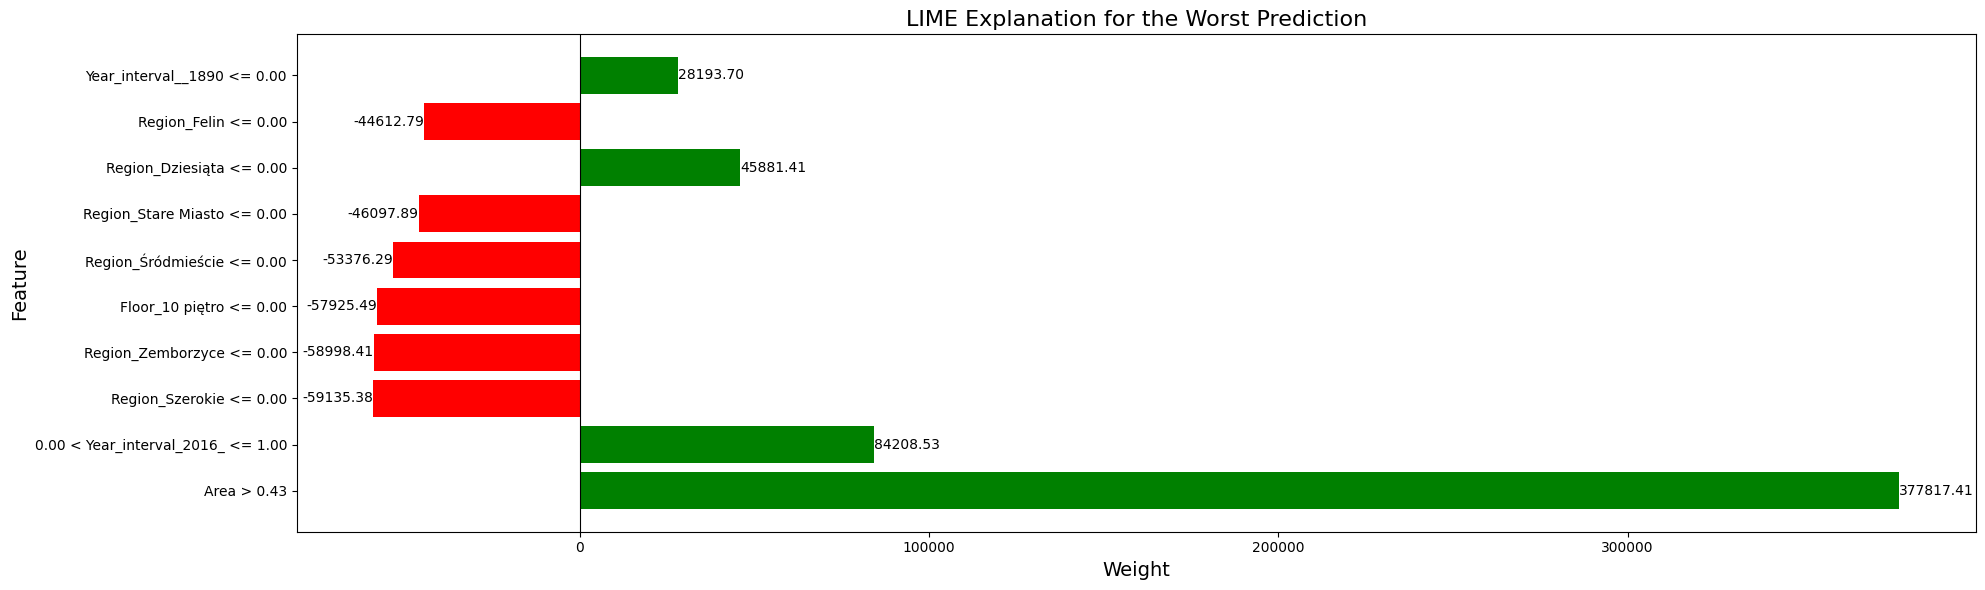

In [186]:
# Calculate errors and find the worst prediction index
errors_rf = np.abs(y_test.values - y_pred)
worst_index_rf = np.argmax(errors_rf)
print(f"Worst Prediction: Real Price: {y_test.iloc[worst_index_rf]}, Predicted Price: {y_pred[worst_index_rf]}")

# Create LIME explainer and explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Price'],
    mode='regression'
)
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[worst_index_rf].values,
    predict_fn=best_random_forest.predict
)

# Extract the explanation details
explanation = exp.as_list()
features, weights = zip(*explanation)

# Create a horizontal bar plot
plt.figure(figsize=(20, 6))
colors = ['green' if w > 0 else 'red' for w in weights]
bars = plt.barh(features, weights, color=colors)
plt.axvline(0, color='black', linewidth=0.8)  # Add a vertical line at x=0
plt.title("LIME Explanation for the Worst Prediction", fontsize=16)
plt.xlabel("Weight", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add numbers on the side of the bars
for bar, weight in zip(bars, weights):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{weight:.2f}', 
             va='center', ha='left' if weight > 0 else 'right', color='black')

plt.tight_layout()
plt.show()

Although random forest showed better results, but for that observation from test set, the model predicted price with very large error,  so let's try to use gradient boosting model to see if it will improve the model.

### XGBoost regression 

In [152]:
# Prepare column names for XGBoost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

#### Build a model

In [166]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
print("Best parameters found: ", xgb_grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.6}


The best parameters found for the XGBoost algorithm indicate a balanced approach with moderate regularization (reg_alpha and reg_lambda) and a learning rate of 0.05, which helps in preventing overfitting. The chosen parameters also suggest a focus on model robustness with a subsample and colsample_bytree of 0.6, and a max_depth of 6 to control the complexity of the trees. Maybe increasing the number of trees will improve the model, but it will take a lot of time to train the model.

#### Evaluate the model

In [167]:
xgb_results = evaluate_model(best_xgb_model, X_test, y_test)
print("XGBoost Results:")
print(xgb_results)

XGBoost Results:
  Metric      Value
0    R^2      0.841
1    MAE  50497.976
2   RMSE  81034.495


XGBoost model showed few better results than Random Forest but there are no such big improvements in metrics, so let's try to use another boosting algorithms and check how they will perform.

### LightGBM regression

#### Build a model

In [43]:
# LightGBM Regression with GridSearchCV
lgb_model = lgb.LGBMRegressor(random_state=42)
param_grid_lgb = {
    'n_estimators': [100, 200,500],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'verbose': [-1]
}
lgb_grid_search = GridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
lgb_grid_search.fit(X_train, y_train)
best_lgb = lgb_grid_search.best_estimator_
print("Best LightGBM parameters found: ", lgb_grid_search.best_params_)


Best LightGBM parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8, 'verbose': -1}


#### Evaluate the model

In [45]:
lgbm_results = evaluate_model(best_lgb, X_test, y_test)
print("LightGBM Results:")
print(lgbm_results)

LightGBM Results:
  Metric      Value
0    R^2      0.806
1    MAE  53314.215
2   RMSE  89686.654


LightGBM model showed weaker results than XGBoost, may be better setting of hyperparameters will improve the model, but it takes a lot of time to train the model, so let's try to use CatBoost model to see how it will perform.

### CatBoost regression

#### Build a model

In [47]:
# CatBoost Regression with GridSearchCV
catboost_model = CatBoostRegressor(silent=True, random_state=42)
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}
catboost_grid_search = GridSearchCV(catboost_model, param_grid_catboost, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
catboost_grid_search.fit(X_train, y_train)
best_catboost = catboost_grid_search.best_estimator_
print("Best CatBoost parameters found: ", catboost_grid_search.best_params_)

Best CatBoost parameters found:  {'border_count': 128, 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.2}


#### Evaluate the model 

In [48]:
catboost_results = evaluate_model(best_catboost, X_test, y_test)
print("CatBoost Results:")
print(catboost_results)

CatBoost Results:
  Metric      Value
0    R^2      0.844
1    MAE  50359.185
2   RMSE  80270.363


CatBoost model showed the best results and took the least time to train the model, compared to the XGBoost algorithm which took much more time to train the model with GridSearchCV. But there are no reasons to discover this model more, because the results are not much higher than the XGBoost model.